In [26]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation
import keras
from keras import backend as K
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame

In [27]:
# 设置随机数，是结果可复现
np.random.seed(42)
from tensorflow import set_random_seed
set_random_seed(2)
import os
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [28]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
# 对取对数的数据还原
def restore_log(num_list):
    for i in range(len(num_list)):
        num_list[i] = np.exp(num_list[i])
    return num_list

# 计算有多少比例的数据误差在per之内
def calc_with_err_per(pre_list_svr,true_list_svr,per=0.2):
    numb=0
    for i in np.arange(len(true_list_svr)):
        errorp=abs(pre_list_svr[i]-true_list_svr[i])/true_list_svr[i]
        if errorp<=per:
            numb=numb+1
        else:
            continue
    Percentageratio=float(numb)/len(true_list_svr)
    return Percentageratio,per

In [31]:
# 导入原始数据，用于还原一阶差分
# 此时数据只进行了累加取log
data = pd.read_csv('data/original_log_7529.csv', parse_dates = True, index_col=0)
data = data[20:]
data.head()

,log_money
data,
2014-01-21,13.956315
2014-01-22,13.849960
2014-01-23,14.364614
2014-01-24,13.654755
2014-01-25,13.946363


测试集为[805:],所以需要的原始数组为[804:],这样对应位置相加就能还原为差分前的数列

In [32]:
before_diff = data.log_money[804:]

In [41]:
# 导入之前清理完成的数据
reframed = pd.read_csv('data/bank_after_clean_20_7529.csv', parse_dates = True, index_col=0)
reframed.head(5)

,count,week_number,weekday,is_quarter_end,holiday,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
data,,,,,,,,,,,,,,,,,,,,,
2014-01-21,3,1,0,0,0,11.766792,13.737225,12.842649,11.999663,12.244331,...,12.006401,13.763059,12.803259,13.580927,13.015001,13.646204,12.468245,11.832106,13.655635,13.017669
2014-01-22,3,2,0,0,0,13.737225,12.842649,11.999663,12.244331,13.778172,...,13.763059,12.803259,13.580927,13.015001,13.646204,12.468245,11.832106,13.655635,13.017669,13.660347
2014-01-23,3,3,0,0,0,12.842649,11.999663,12.244331,13.778172,12.552495,...,12.803259,13.580927,13.015001,13.646204,12.468245,11.832106,13.655635,13.017669,13.660347,13.050653
2014-01-24,3,4,0,0,0,11.999663,12.244331,13.778172,12.552495,13.580927,...,13.580927,13.015001,13.646204,12.468245,11.832106,13.655635,13.017669,13.660347,13.050653,13.646204
2014-01-25,3,5,1,0,0,12.244331,13.778172,12.552495,13.580927,12.874415,...,13.015001,13.646204,12.468245,11.832106,13.655635,13.017669,13.660347,13.050653,13.646204,12.850817


In [42]:
reframed = reframed[['count', 'week_number', 'weekday', 'var1(t-9)', 
                     'var1(t-7)', 'var1(t-5)', 'var1(t-2)', 'var1(t-1)','var1(t)']]
# reframed = reframed[10:]

In [43]:
values = reframed.values

In [44]:
test = values[805:, :]
true_y = test[:, -1]

In [45]:
# 选取分割点，划分数据集为训练集和测试集，并把特征转换为3维
def data_split(values,point):
    train = values[:point, :]
    test = values[point:, :]
    train_X, train_y = train[:,:-1], train[:, -1]
    test_X, test_y = test[:,:-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
#     print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    return train_X,train_y,test_X,test_y

In [12]:
# train = values[:805, :]
# test = values[805:, :]
# train_X, train_y = train[:,:-1], train[:, -1]
# test_X, test_y = test[:,:-1], test[:, -1]

In [13]:
# # 转换为3维
# train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

In [14]:
# train_X.shape, test_X.shape, train_y.shape, test_y.shape

In [15]:
# test_X[0].shape

In [49]:
train_X,train_y,test_X,test_y = data_split(values,805+i)

model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1],train_X.shape[2]),
               activation='relu',return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(32,activation='relu',kernel_initializer='random_uniform',
                bias_initializer='zeros'))
# model.add(Dropout(0.5))
# # model.add(LSTM(16,activation='relu',return_sequences=False))
# model.add(Dense(16,kernel_initializer='random_uniform',
#                 bias_initializer='zeros'))
model.add(Dense(1))
opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mae',optimizer=opt)

history = model.fit(train_X, train_y, epochs = 50, batch_size=64, 
                validation_data=(test_X, test_y),verbose = 0,shuffle=False)
pre_next = float(model.predict(test_X[0].reshape((1,1,8))))
print(pre_next)

12.4138631821


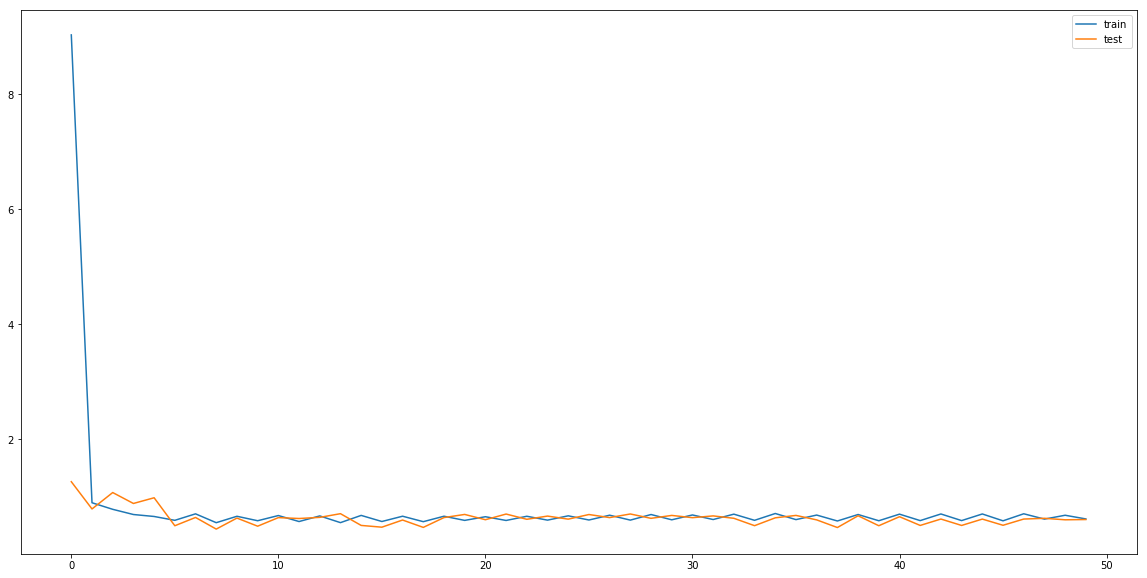

In [50]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
# 滚动预测
pre_list = []

for i in range(277):
    train_X,train_y,test_X,test_y = data_split(values,805+i)

    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1],train_X.shape[2]),
                   activation='relu',return_sequences=False))
    # model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu',kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    # model.add(Dropout(0.5))
    # # model.add(LSTM(16,activation='relu',return_sequences=False))
    # model.add(Dense(16,kernel_initializer='random_uniform',
    #                 bias_initializer='zeros'))
    model.add(Dense(1))
    opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mae',optimizer=opt)

    history = model.fit(train_X, train_y, epochs = 50, batch_size=64, 
                    validation_data=(test_X, test_y),verbose = 0,shuffle=False)
    pre_next = float(model.predict(test_X[0].reshape((1,1,8))))
    print(pre_next)
    pre_list.append(pre_next)

12.4077453613
13.3518619537
12.5698204041
12.161072731
11.491399765
11.786075592
12.9908533096
12.5269985199
13.9730405807
12.5280437469
12.2986650467
12.0906600952
11.8247880936
12.0767374039
12.3789663315
13.5249605179
13.3084087372
12.7556848526
11.8917150497
12.5713481903
11.9325304031
12.6857557297
12.4801111221
12.6580963135
12.9428491592
11.6916646957
12.1746482849
12.9027519226
11.7577886581
11.9188022614
11.7911701202
11.9519891739
11.6469516754
11.8148336411
11.7615060806
11.7329702377
13.6353263855
13.4432449341
13.0471906662
12.4675512314
12.470451355
11.9456539154
12.1491155624
13.900094986
12.6218509674
12.0516862869
11.5105237961
11.4472999573
12.1346635818
12.621254921
12.9463176727
12.6239013672
12.1153554916
11.6207637787
11.4460296631
12.2618112564
13.2442073822
12.1934299469
13.4108333588
12.220533371
11.9275903702
11.9269371033
12.4916725159
13.8346939087
12.4468336105
12.3715600967
12.3918085098
11.4411554337
11.7861814499
12.8476114273
12.5964822769
12.4769029617

In [52]:
pre_list

[12.407745361328125,
 13.351861953735352,
 12.569820404052734,
 12.161072731018066,
 11.491399765014648,
 11.786075592041016,
 12.990853309631348,
 12.526998519897461,
 13.973040580749512,
 12.528043746948242,
 12.298665046691895,
 12.090660095214844,
 11.824788093566895,
 12.076737403869629,
 12.378966331481934,
 13.5249605178833,
 13.308408737182617,
 12.755684852600098,
 11.891715049743652,
 12.571348190307617,
 11.932530403137207,
 12.685755729675293,
 12.480111122131348,
 12.658096313476562,
 12.942849159240723,
 11.691664695739746,
 12.17464828491211,
 12.902751922607422,
 11.75778865814209,
 11.918802261352539,
 11.791170120239258,
 11.95198917388916,
 11.646951675415039,
 11.814833641052246,
 11.761506080627441,
 11.732970237731934,
 13.635326385498047,
 13.443244934082031,
 13.04719066619873,
 12.467551231384277,
 12.470451354980469,
 11.945653915405273,
 12.149115562438965,
 13.900094985961914,
 12.621850967407227,
 12.05168628692627,
 11.510523796081543,
 11.44729995727539,


In [53]:
# pre_list = pre_list.tolist()
true_list = true_y.tolist()

In [54]:
len(pre_list), len(true_list)

(277, 277)

In [55]:
pre_list[:10]

[12.407745361328125,
 13.351861953735352,
 12.569820404052734,
 12.161072731018066,
 11.491399765014648,
 11.786075592041016,
 12.990853309631348,
 12.526998519897461,
 13.973040580749512,
 12.528043746948242]

In [56]:
true_list[:10]

[13.457549072500074,
 12.306822548630313,
 12.502094842256955,
 13.489641904127252,
 11.899887101513832,
 12.001198684265706,
 12.535736040222053,
 13.457549072500074,
 12.87107752014384,
 12.1177877306626]

In [57]:
restore_pre = restore_log(pre_list)

restore_true = restore_log(true_list)

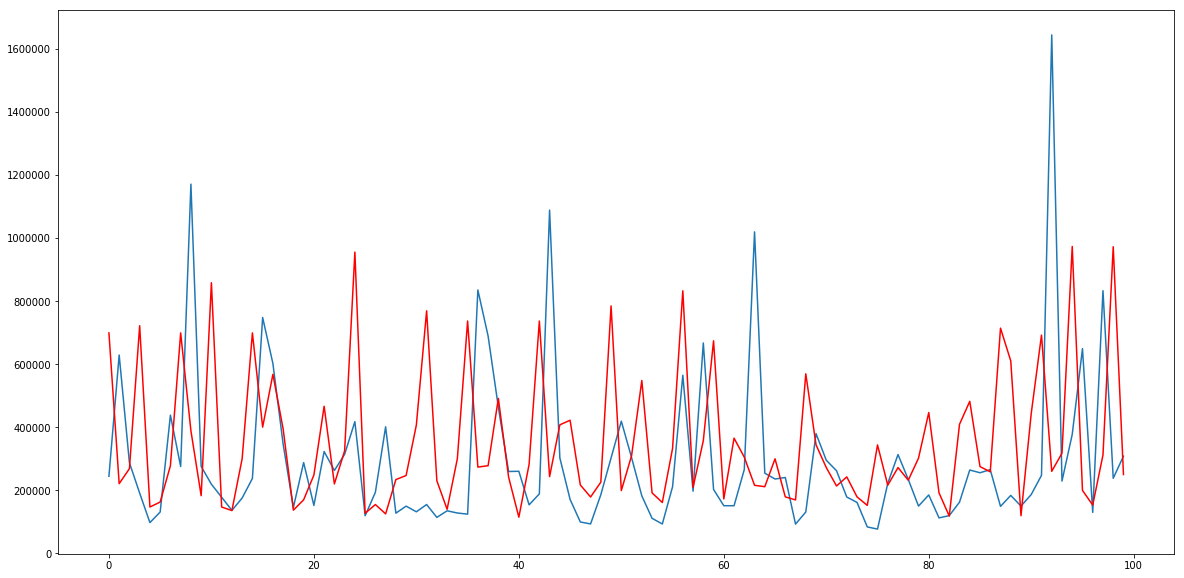

In [58]:
plt.plot(restore_pre[:100])
plt.plot(restore_true[:100], color='red')
plt.show()

In [59]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre,restore_true))))
print('误差：%.2f%%'%float((error/len(restore_true))*100))

误差：63.61%


In [61]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(restore_pre)):
    if restore_pre[i] > restore_true[i]:
        count += 1
ratio = count*1.0/len(restore_true)
print("覆盖率为：%.2f%%"% (ratio*100))

覆盖率为：39.71%


In [65]:
# 计算有 多少比例 的数据误差在 20.00% 之内
Percentageratio,per = calc_with_err_per(restore_pre,restore_true,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 23.83% 的数据误差在 20.00% 之内
